In [1]:
import numpy as np
import pandas as pd

In [2]:
!pip install datasets==2.16.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.6 MB/s eta 0:00:00


In [3]:
import datasets
datasets.__version__

'2.16.0'

In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.corpus import wordnet
import warnings
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
import re
import nltk
import seaborn as sn
nltk.download('wordnet')
nltk.download("stopwords")
lemmatizer= PorterStemmer()
nltk.download('omw-1.4')
from nltk.corpus import stopwords
nltk.download('punkt')
stop_words = set(stopwords.words("english"))
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import pipeline
import numpy as np
from sklearn.preprocessing import LabelEncoder
from transformers import TFAutoModel,AutoTokenizer
from sklearn.ensemble import RandomForestClassifier
from prettytable import PrettyTable

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
from datasets import load_dataset
emotions_train = load_dataset("csv", data_files="/content/train.txt", sep=";", names=["text", "label"])
emotions_valid = load_dataset("csv", data_files="/content/val.txt", sep=";", names=["text", "label"])
emotions_test = load_dataset("csv", data_files="/content/test.txt", sep=";", names=["text", "label"])

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [7]:
emotions_train

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
})

In [10]:
emotions_train['train'][0:4]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property'],
 'label': ['sadness', 'sadness', 'anger', 'love']}

In [11]:
emotions_train = emotions_train.filter(lambda x:x['text'] is not None)
emotions_valid = emotions_valid.filter(lambda x:x['text'] is not None)
emotions_test = emotions_test.filter(lambda x:x['text'] is not None)

Filter:   0%|          | 0/16000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [13]:
emotions_train.set_format(type="pandas")
df = emotions_train['train'][:]
df.head(3)

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger


In [14]:
df.label.unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

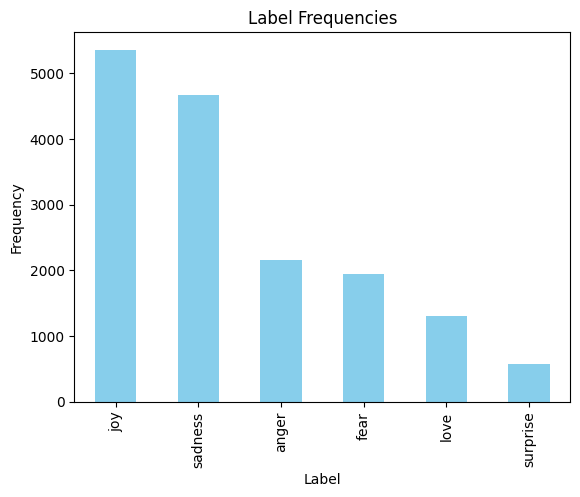

In [16]:

df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Label Frequencies')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

Training Model Using TFIDF and Random Forest


In [17]:
emotions_train.set_format('pandas')
emotions_valid.set_format('pandas')
emotions_test.set_format('pandas')
df_val = emotions_valid['train'][:]
df_test = emotions_test['train'][:]
df_train = emotions_train['train'][:]

In [18]:
def Stemming(text):
    stemmer= PorterStemmer()
    text = text.split()
    text=[stemmer.stem(y) for y in text]
    return " " .join(text)

def remove_stop_words(text):
    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)
def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):
    text = text.split()
    text=[y.lower() for y in text]
    return " " .join(text)

def Removing_punctuations(text):
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()


def normalize_text(df):
    df.text=df.text.apply(lambda text : lower_case(text))
    df.text=df.text.apply(lambda text : remove_stop_words(text))
    df.text=df.text.apply(lambda text : Removing_numbers(text))
    df.text=df.text.apply(lambda text : Removing_punctuations(text))
    df.text=df.text.apply(lambda text : Stemming(text))
    return df

df = normalize_text(df_train)
df_val = normalize_text(df_val)
df_test = normalize_text(df_test)

In [19]:
df.head()

,text,label
0,didnt feel humili,sadness
1,go feel hopeless damn hope around someon care ...,sadness
2,im grab minut post feel greedi wrong,anger
3,ever feel nostalg fireplac know still properti,love
4,feel grouchi,anger


In [20]:
train_df = df_train
val_df = df_val
test_df = df_test

In [21]:
vectorizer = TfidfVectorizer(max_features=30000, ngram_range=(1, 2))

In [22]:
train_features = vectorizer.fit_transform(train_df['text'])

In [23]:
val_features = vectorizer.transform(val_df['text'])
test_features = vectorizer.transform(test_df['text'])

In [24]:
label_encoder = LabelEncoder()
train_df['encoded_label'] = label_encoder.fit_transform(train_df['label'])
val_df['encoded_label'] = label_encoder.transform(val_df['label'])
test_df['encoded_label'] = label_encoder.transform(test_df['label'])

In [25]:
best_n_estimators = None
best_max_depth = None
best_val_accuracy = 0.0

for n_estimators in [ 50, 100]:
    for max_depth in [10,50,100,200]:
        rf_classifier = RandomForestClassifier(
            n_jobs = -1,
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=42,
            min_samples_leaf=5
        )

        rf_classifier.fit(train_features, train_df['encoded_label'])


In [29]:
train_predictions = rf_classifier.predict(train_features)
val_predictions = rf_classifier.predict(val_features)
train_accuracy = accuracy_score(train_df['encoded_label'], train_predictions)
val_accuracy = accuracy_score(val_df['encoded_label'], val_predictions)

In [32]:
if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_n_estimators = n_estimators
            best_max_depth = max_depth
print('Train accuracy: ',train_accuracy)
print('Validation accuracy: ',val_accuracy)
print('best_n_estimators: ',n_estimators)
print('best_max_depth: ',max_depth)
print("-"*10)

Train accuracy:  0.8679375
Validation accuracy:  0.8535
best_n_estimators:  100
best_max_depth:  200
----------


In [33]:
best_n_estimators=  50
best_max_depth=  200
final_rf_classifier = RandomForestClassifier(n_jobs = -1,n_estimators=best_n_estimators, max_depth=best_max_depth,min_samples_leaf=5, random_state=42)
final_rf_classifier.fit(train_features, train_df['encoded_label'])


RandomForestClassifier(max_depth=200, min_samples_leaf=5, n_estimators=50,
                       n_jobs=-1, random_state=42)

In [34]:
test_predictions = final_rf_classifier.predict(test_features)


In [35]:
test_accuracy = accuracy_score(test_df['encoded_label'], test_predictions)
test_conf_matrix = confusion_matrix(test_df['encoded_label'], test_predictions)
test_classification_rep = classification_report(test_df['encoded_label'], test_predictions)


In [36]:
print("Best Hyperparameters:")
print(f"n_estimators: {best_n_estimators}, max_depth: {best_max_depth}")
print(f"Accuracy on Test Set: {test_accuracy:.4f}")
print("\nClassification Report:")
print(test_classification_rep)

Best Hyperparameters:
n_estimators: 50, max_depth: 200
Accuracy on Test Set: 0.8510

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.80      0.83       275
           1       0.87      0.84      0.86       224
           2       0.80      0.96      0.87       695
           3       0.85      0.44      0.58       159
           4       0.92      0.90      0.91       581
           5       0.76      0.58      0.66        66

    accuracy                           0.85      2000
   macro avg       0.85      0.75      0.78      2000
weighted avg       0.86      0.85      0.84      2000



Trying One Shot Classification From Hugging Face:

In [37]:
emotions_test.set_format('pandas')
df_test = emotions_test['train'][:]

In [38]:
df_test[25:30]

,text,label
25,i hate it when i feel fearful for absolutely n...,fear
26,i am feeling outraged it shows everywhere,anger
27,i stole a book from one of my all time favorit...,sadness
28,i do feel insecure sometimes but who doesnt,fear
29,i highly recommend visiting on a wednesday if ...,anger


In [39]:
classifier = pipeline("zero-shot-classification")

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [40]:
def classify_text(text):
    result = classifier(text, candidate_labels=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'])
    return result['labels'][0] if result['labels'] else None

In [41]:
print('Actual Labels: ',df_test['text'][0:10].map(lambda x: classify_text(x)).values)
print('Predictions: ',df_test['label'][0:10].values)

Actual Labels:  ['sadness' 'sadness' 'love' 'surprise' 'surprise' 'surprise' 'anger'
 'surprise' 'surprise' 'surprise']
Predictions:  ['sadness' 'sadness' 'sadness' 'joy' 'sadness' 'fear' 'anger' 'joy' 'joy'
 'anger']


HUGGING FACE AND FINE-TUNED BERT:

In [42]:
emotions_train.reset_format()
emotions_valid.reset_format()
emotions_test.reset_format()

In [43]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [44]:
emotions_train

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
})

In [45]:
def tokenize_function(example):
    return tokenizer(example["text"], padding=True, truncation=True)

In [46]:
tokenized_datasets_train = emotions_train.map(tokenize_function, batched=True, batch_size=None)
tokenized_datasets_val = emotions_valid.map(tokenize_function, batched=True, batch_size=None)
tokenized_datasets_test = emotions_test.map(tokenize_function, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [47]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [48]:
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(tokenized_datasets_train["train"]["label"])
tokenized_datasets_train["train"] = tokenized_datasets_train["train"].add_column("label_encoded", label_encoded)
label_encoded = label_encoder.transform(tokenized_datasets_val["train"]["label"])
tokenized_datasets_val["train"] = tokenized_datasets_val["train"].add_column("label_encoded", label_encoded)
label_encoded = label_encoder.transform(tokenized_datasets_test["train"]["label"])
tokenized_datasets_test["train"] = tokenized_datasets_test["train"].add_column("label_encoded", label_encoded)

In [49]:
tokenized_datasets_train = tokenized_datasets_train.rename_column(
    original_column_name="label_encoded", new_column_name="label_ids"
)
tokenized_datasets_val = tokenized_datasets_val.rename_column(
    original_column_name="label_encoded", new_column_name="label_ids"
)
tokenized_datasets_test = tokenized_datasets_test.rename_column(
    original_column_name="label_encoded", new_column_name="label_ids"
)

In [50]:
model_ckpt = "distilbert-base-uncased"
model = TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=6)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [51]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_datasets_train["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)
tf_val_set = model.prepare_tf_dataset(
    tokenized_datasets_val["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)
tf_test_set = model.prepare_tf_dataset(
    tokenized_datasets_test["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)
tf_test_set

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(16, 66), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 66), dtype=tf.int64, name=None)}, TensorSpec(shape=(16,), dtype=tf.int64, name=None))>

In [52]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy())

In [53]:
model.fit(tf_train_set, validation_data=tf_val_set, epochs=2)

Epoch 1/2
1000/1000 [==============================] - 201s 175ms/step - loss: 0.3948 - sparse_categorical_accuracy: 0.8576 - val_loss: 0.1986 - val_sparse_categorical_accuracy: 0.9225
Epoch 2/2
1000/1000 [==============================] - 153s 153ms/step - loss: 0.1384 - sparse_categorical_accuracy: 0.9373 - val_loss: 0.1775 - val_sparse_categorical_accuracy: 0.9280


In [54]:
def make_preds(example):
    output_logits = model.predict([example["input_ids"]],verbose=0).logits
    return {'preds': np.argmax(output_logits)}

In [57]:
tokenized_datasets_test["train"]=tokenized_datasets_test["train"].map(make_preds)
print('Test Accuracy:',test_accuracy)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Test Accuracy: 0.851


Text(95.72222222222221, 0.5, 'Truth')

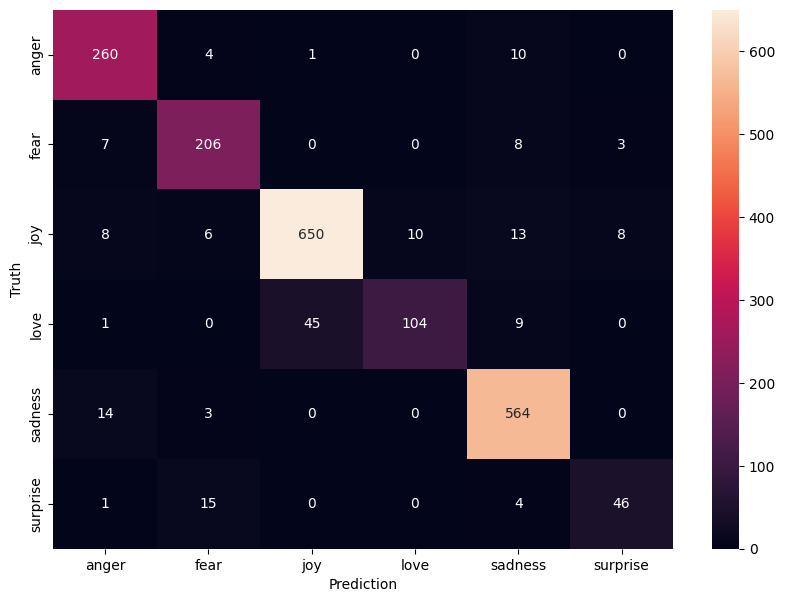

In [58]:
test_conf_matrix = confusion_matrix(tokenized_datasets_test["train"]["label_ids"], tokenized_datasets_test["train"]['preds'])

class_labels = label_encoder.classes_
plt.figure(figsize = (10,7))
sn.heatmap(test_conf_matrix, annot=True, fmt='d',xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Prediction')
plt.ylabel('Truth')

In [59]:
def predict_fn(text):
    inputs = tokenizer(text, return_tensors="tf",truncation = True,padding = True)
    logits = model(inputs).logits
    return logits.numpy()

In [61]:
predict_fn('i am so happy today , finally got a job offer')

array([[-0.70845205, -2.1971602 ,  4.957406  , -1.0094972 , -0.9496648 ,
        -3.300071  ]], dtype=float32)